In this file, we are conducting experiment to explore the how the performance of our model gonna change with different proportion of training data
For the 600 total data, we are going to build below models

'Model B.1.1 RBF train:test = 9:1'

'Model B.1.2 RBF + Periodic train:test = 9:1'

'Model B.2.1 RBF train:test = 8:2'

'Model B.2.2 RBF + Periodic train:test = 8:2'

'Model B.3.1 RBF train:test = 7:3'

'Model B.3.2 RBF + Periodic train:test = 7:3'

'Model B.4.1 RBF train:test = 6:4'

'Model B.4.2 RBF + Periodic train:test = 6:4'

'Model B.5.1 RBF train:test = 5:5'

'Model B.5.2 RBF + Periodic train:test = 5:5'

'Model B.6.1 RBF train:test = 4:6'

'Model B.6.2 RBF + Periodic train:test = 4:6'

'Model B.7.1 RBF train:test = 3:7'

'Model B.7.2 RBF + Periodic train:test = 3:7'

'Model B.8.1 RBF train:test = 2:8'

'Model B.8.2 RBF + Periodic train:test = 2:8'

'Model B.9.1 RBF train:test = 1:9'

'Model B.9.2 RBF + Periodic train:test = 1:9'

In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import time
from gpytorch.likelihoods import FixedNoiseGaussianLikelihood
import random
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Make plots inline
%matplotlib inline

# 1 Read Data

In [2]:
#read the data and create data frame
df = pd.read_csv('heart_rate_data.csv')
df['time'] = np.linspace(0, 900, len(df))
df.columns = ['Y','time']
#normalize Y
Y = df['Y'].to_numpy().reshape(-1, 1)
transformer = StandardScaler().fit(Y)
df['Y'] = transformer.transform(Y)
print(df.shape)
df.head(3)

(1799, 2)


,Y,time
0,-1.518649,0.000000
1,-1.556528,0.500556
2,-1.266271,1.001112


In [3]:
#get the tensor for x axis in posterier inference
X_all_linspace = np.arange(0, float(df['time'][600]), 0.5)
X_all_linspace = torch.tensor(X_all_linspace)

# 2 Build Model & Experiment

## Settings and Functions for Experiment

In [4]:
random.seed(666)

In [5]:
#we have 9 *  2 = 18 experiment in our first set
model_name_list = \
[['Model B.1.1 RBF (Testsize = 0.1)',\
'Model B.1.2 RBF + Periodic (Testsize = 0.1)'],\
['Model B.2.1 RBF (Testsize = 0.1)',\
'Model B.2.2 RBF + Periodic (Testsize = 0.1)'],
['Model B.3.1 RBF (Testsize = 0.1)',\
'Model B.3.2 RBF + Periodic (Testsize = 0.1)'],
['Model B.4.1 RBF (Testsize = 0.1)',\
'Model B.4.2 RBF + Periodic (Testsize = 0.1)'],
['Model B.5.1 RBF (Testsize = 0.1)',\
'Model B.5.2 RBF + Periodic (Testsize = 0.1)'],
['Model B.6.1 RBF (Testsize = 0.1)',\
'Model B.6.2 RBF + Periodic (Testsize = 0.1)'],
['Model B.7.1 RBF (Testsize = 0.1)',\
'Model B.7.2 RBF + Periodic (Testsize = 0.1)'],
['Model B.8.1 RBF (Testsize = 0.1)',\
'Model B.8.2 RBF + Periodic (Testsize = 0.1)'],
['Model B.9.1 RBF (Testsize = 0.1)',\
'Model B.9.2 RBF + Periodic (Testsize = 0.1)']]

In [6]:
kernel_list = [gpytorch.kernels.RBFKernel(), gpytorch.kernels.RBFKernel() + gpytorch.kernels.PeriodicKernel()]

In [11]:
def plot_predicting_result(model1, likelihood1, experiment_index1, model2, likelihood2, experiment_index2, X_train, Y_train, X_test, Y_test):
    model1.eval()
    likelihood1.eval()
    with torch.no_grad():
        all_prediction1 = likelihood1(model1(X_all_linspace))
        all_mean1 = all_prediction1.mean
        all_lower1, all_upper1 = all_prediction1.confidence_region()

    model2.eval()
    likelihood2.eval()
    with torch.no_grad():
        all_prediction2 = likelihood2(model2(X_all_linspace))
        all_mean2 = all_prediction2.mean
        all_lower2, all_upper2 = all_prediction2.confidence_region()
    
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))

    axs[0].plot(X_train, Y_train, 'y.', markersize=10, label='Training Data') #plot training data
    axs[0].plot(X_test, Y_test, 'bx', markersize=6, label='Testing Data') #plot testing data
    axs[0].plot(X_all_linspace, all_mean1, 'g-', label='Posterier Mean') # plot training prediction
    axs[0].fill_between(X_all_linspace, all_lower1, all_upper1, alpha=0.5, label = 'Posterior CI') #add CI
    axs[0].set_xlabel('$x$')
    axs[0].set_ylabel('$f(x)$')
    axs[0].set_title(model_name_list[experiment_index1[0]][experiment_index1[1]])
    axs[0].legend(loc='upper left')

    axs[1].plot(X_train, Y_train, 'y.', markersize=10, label='Training Data') #plot training data
    axs[1].plot(X_test, Y_test, 'bx', markersize=6, label='Testing Data') #plot testing data
    axs[1].plot(X_all_linspace, all_mean2, 'g-', label='Posterier Mean') # plot training prediction
    axs[1].fill_between(X_all_linspace, all_lower2, all_upper2, alpha=0.5, label = 'Posterior CI') #add CI
    axs[1].set_xlabel('$x$')
    axs[1].set_ylabel('$f(x)$')
    axs[1].set_title(model_name_list[experiment_index2[0]][experiment_index2[1]])
    axs[1].legend(loc='upper left')


    fig_name = 'Experiment B.' + str(experiment_index2[0]+1) + ' Inference Result '\
        '(Test Size = 0.' + str(experiment_index2[0] + 1) + ')'
    fig.suptitle(fig_name)
    save_to = 'Experiment_B_Figure/' + fig_name + '.png'
    plt.savefig(save_to)
    plt.show()
    plt.close()

In [12]:
def training(X_train, Y_train, X_test, Y_test, model, likelihood, optimizer, mll, training_iterations = 300):
    start_time = time.time()
    train_losses_mll = []
    test_losses_mse = []
    test_losses_msll = []
    time_list = []

    for epoch in range(training_iterations):
        #get train loss for this iter
        model.train()
        likelihood.train()
        optimizer.zero_grad()
        train_predition = model(X_train)
        train_loss = -mll(train_predition, Y_train)        
        train_losses_mll.append(train_loss)
        time_list.append(time.time() - start_time)
        train_loss.backward()
        optimizer.step()

        #get test loss for this iter
        model.eval()
        with torch.no_grad():
            trained_pred_dist = likelihood(model(X_test))
            predictive_mean = trained_pred_dist.mean
            lower, upper = trained_pred_dist.confidence_region()
            #here we use mse instead of marginal log likelihood because 
            #ow error occur: Matrix not positive definite after repeatedly adding jitter up to 1.0e-06
            test_msll = gpytorch.metrics.mean_standardized_log_loss(trained_pred_dist, Y_test)
            test_mse = np.mean(np.square(np.array(predictive_mean - Y_test)))
            test_losses_mse.append(test_mse)
            test_losses_msll.append(test_msll)
    
    end_time = time.time()
    train_losses_mll = [float(i) for i in train_losses_mll]
    test_losses_mse = [float(i) for i in test_losses_mse]
    test_losses_msll = [float(i) for i in test_losses_msll]

    print('tesing MSE after', training_iterations, 'epochs:', test_losses_mse[-1])
    print('tesing MSLL after', training_iterations, 'epochs:', test_losses_msll[-1])
    print('training duration for', training_iterations, 'epochs:', end_time - start_time)

    return time_list, train_losses_mll, test_losses_mse, test_losses_msll, end_time - start_time

In [41]:
def GP_experiment(experiment_index, X_train, Y_train):
    current_experiment_index = experiment_index
    #define the model
    class GPRegressionModel(gpytorch.models.ExactGP):
        def __init__(self, train_x, train_y, likelihood, experiment_index):
            super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
            self.mean_module = gpytorch.means.ConstantMean()
            self.covar_module = gpytorch.kernels.ScaleKernel(kernel_list[experiment_index[1]])
            print(self.covar_module)

        def forward(self, x):
            mean_x = self.mean_module(x)
            covar_x = self.covar_module(x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    #training
    likelihood = FixedNoiseGaussianLikelihood(torch.ones(len(X_train))* 0.01, learn_additional_noise=True)
    model = GPRegressionModel(X_train, Y_train, likelihood, current_experiment_index)
    
    if torch.cuda.is_available():
        model = model.cuda()
        likelihood = likelihood.cuda()
    
    return model, likelihood

In [14]:
#These lists are for comparing training speed and performance for different models later
time_list_list = [[None]*2, [None]*2, [None]*2, [None]*2, [None]*2, [None]*2, [None]*2, [None]*2, [None]*2]
train_losses_mll_list = [[None]*2, [None]*2, [None]*2, [None]*2, [None]*2, [None]*2, [None]*2, [None]*2, [None]*2]
test_losses_mse_list = [[None]*2, [None]*2, [None]*2, [None]*2, [None]*2, [None]*2, [None]*2, [None]*2, [None]*2]
test_losses_msll_list = [[None]*2, [None]*2, [None]*2, [None]*2, [None]*2, [None]*2, [None]*2, [None]*2, [None]*2]
inference_duration_list = [[None]*2, [None]*2, [None]*2, [None]*2, [None]*2, [None]*2, [None]*2, [None]*2, [None]*2]

In [15]:
#function to add training log of current model to our record list above
def record(time_list, train_losses_mll, test_losses_mse, test_losses_msll, current_experiment_index):
    time_list_list[current_experiment_index[0]][current_experiment_index[1]] = time_list
    train_losses_mll_list[current_experiment_index[0]][current_experiment_index[1]] = train_losses_mll
    test_losses_mse_list[current_experiment_index[0]][current_experiment_index[1]] = test_losses_mse
    test_losses_msll_list[current_experiment_index[0]][current_experiment_index[1]] = test_losses_msll

In [16]:
def get_current_training_testing_split(experiment_index):
    testing_size = (experiment_index[0]+1)/10 #index range [0, 8]
    X_train_, X_test_, Y_train_, Y_test_ = train_test_split(df['time'][:600], df['Y'][:600], test_size = testing_size, random_state= 66)
    X_train_, Y_train_, X_test_, Y_test_ = X_train_.sort_index(), Y_train_.sort_index(), X_test_.sort_index(), Y_test_.sort_index()
    X_train_, Y_train_, X_test_, Y_test_  = np.array(X_train_), np.array(Y_train_), np.array(X_test_), np.array(Y_test_)
    X_train, Y_train, X_test, Y_test = torch.tensor(X_train_), torch.tensor(Y_train_), torch.tensor(X_test_), torch.tensor(Y_test_)
    return X_train, Y_train, X_test, Y_test

### EXP B.1: Testsize = 0.1

ScaleKernel(
  (base_kernel): RBFKernel(
    (raw_lengthscale_constraint): Positive()
    (distance_module): Distance()
  )
  (raw_outputscale_constraint): Positive()
)
tesing MSE after 300 epochs: 0.03021909682215455
tesing MSLL after 300 epochs: -0.6465402717123402
training duration for 300 epochs: 13.075013875961304
ScaleKernel(
  (base_kernel): AdditiveKernel(
    (kernels): ModuleList(
      (0): RBFKernel(
        (raw_lengthscale_constraint): Positive()
        (distance_module): Distance()
      )
      (1): PeriodicKernel(
        (raw_lengthscale_constraint): Positive()
        (raw_period_length_constraint): Positive()
        (distance_module): Distance()
      )
    )
  )
  (raw_outputscale_constraint): Positive()
)
tesing MSE after 300 epochs: 0.0304071599610047
tesing MSLL after 300 epochs: -0.6441151128087167
training duration for 300 epochs: 21.940706968307495


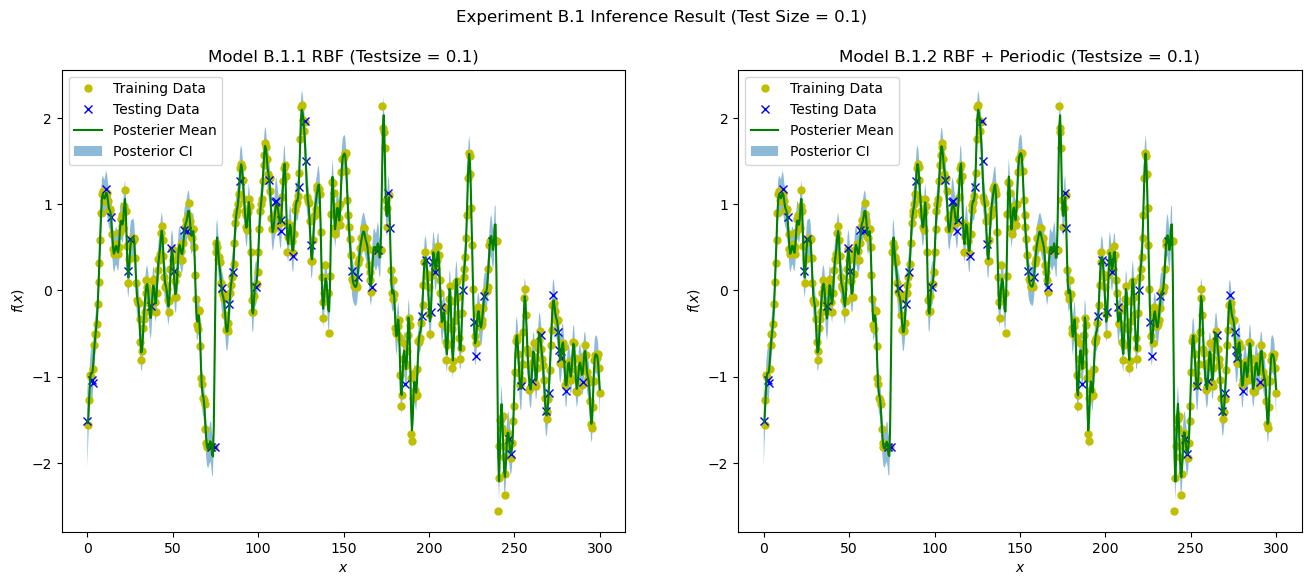

In [42]:
experiment_index1 = [0, 0]
experiment_index2 = [0, 1]

#get current training and testing set
X_train, Y_train, X_test, Y_test = get_current_training_testing_split(experiment_index1)

#get our current model and likelihood
model1, likelihood1 = GP_experiment(experiment_index1, X_train, Y_train)
time_list, train_losses_mll, test_losses_mse, test_losses_msll, training_duration =  \
    training(X_train, Y_train, X_test, Y_test, model1, likelihood1, optimizer = torch.optim.Adam(model1.parameters(), lr=0.1),\
         mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood1, model1), training_iterations = 300)
record(time_list, train_losses_mll, test_losses_mse, test_losses_msll, experiment_index1)

model2, likelihood2 = GP_experiment(experiment_index2, X_train, Y_train)
time_list, train_losses_mll, test_losses_mse, test_losses_msll, training_duration =  \
    training(X_train, Y_train, X_test, Y_test, model2, likelihood2, optimizer = torch.optim.Adam(model2.parameters(), lr=0.1),\
         mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood2, model2), training_iterations = 300)
record(time_list, train_losses_mll, test_losses_mse, test_losses_msll, experiment_index2)

plot_predicting_result(model1, likelihood1, experiment_index1, model2, likelihood2, experiment_index2, X_train, Y_train, X_test, Y_test)

### EXP B.2: Testsize = 0.2

tesing MSE after 300 epochs: 0.025431974068722395
tesing MSLL after 300 epochs: -0.667279725121769
training duration for 300 epochs: 11.444821834564209
tesing MSE after 300 epochs: 0.02662926867063977
tesing MSLL after 300 epochs: -0.653209453184189
training duration for 300 epochs: 20.088374853134155


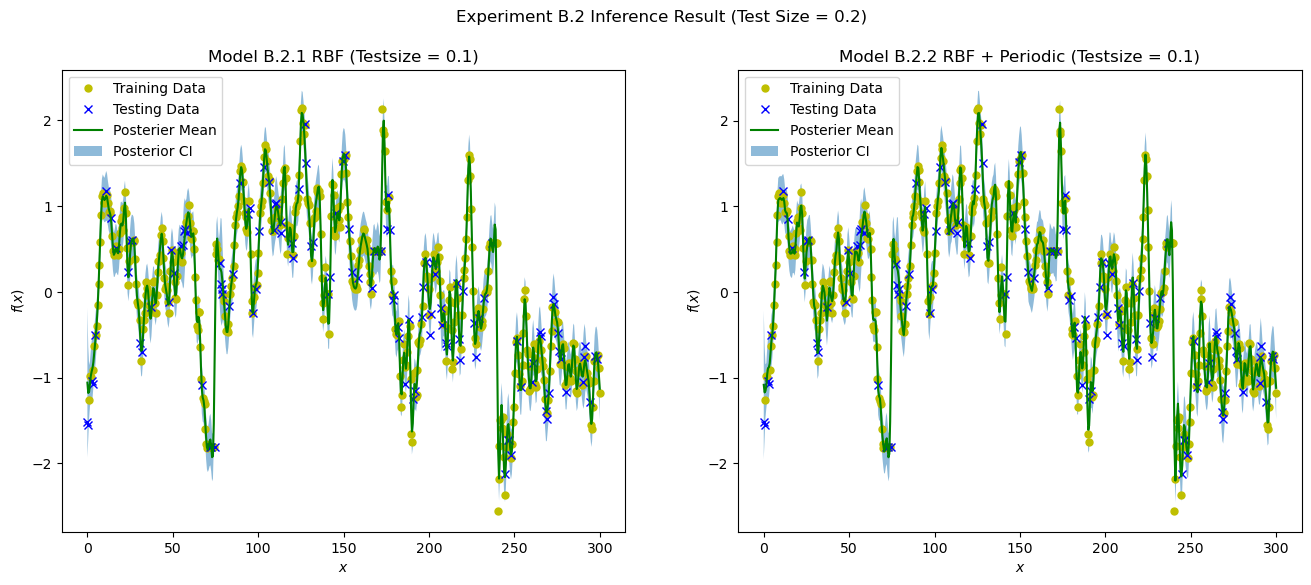

In [18]:
experiment_index1 = [1, 0]
experiment_index2 = [1, 1]

#get current training and testing set
X_train, Y_train, X_test, Y_test = get_current_training_testing_split(experiment_index1)

#get our current model and likelihood
model1, likelihood1 = GP_experiment(experiment_index1, X_train, Y_train)
time_list, train_losses_mll, test_losses_mse, test_losses_msll, training_duration =  \
    training(X_train, Y_train, X_test, Y_test, model1, likelihood1, optimizer = torch.optim.Adam(model1.parameters(), lr=0.1),\
         mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood1, model1), training_iterations = 300)
record(time_list, train_losses_mll, test_losses_mse, test_losses_msll, experiment_index1)

model2, likelihood2 = GP_experiment(experiment_index2, X_train, Y_train)
time_list, train_losses_mll, test_losses_mse, test_losses_msll, training_duration =  \
    training(X_train, Y_train, X_test, Y_test, model2, likelihood2, optimizer = torch.optim.Adam(model2.parameters(), lr=0.1),\
         mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood2, model2), training_iterations = 300)
record(time_list, train_losses_mll, test_losses_mse, test_losses_msll, experiment_index2)

plot_predicting_result(model1, likelihood1, experiment_index1, model2, likelihood2, experiment_index2, X_train, Y_train, X_test, Y_test)

### EXP B.3: Testsize = 0.3

tesing MSE after 300 epochs: 0.04452612483686876
tesing MSLL after 300 epochs: -0.42518369684273505
training duration for 300 epochs: 9.991132974624634
tesing MSE after 300 epochs: 0.044901835720310326
tesing MSLL after 300 epochs: -0.4258251700868262
training duration for 300 epochs: 16.751976013183594


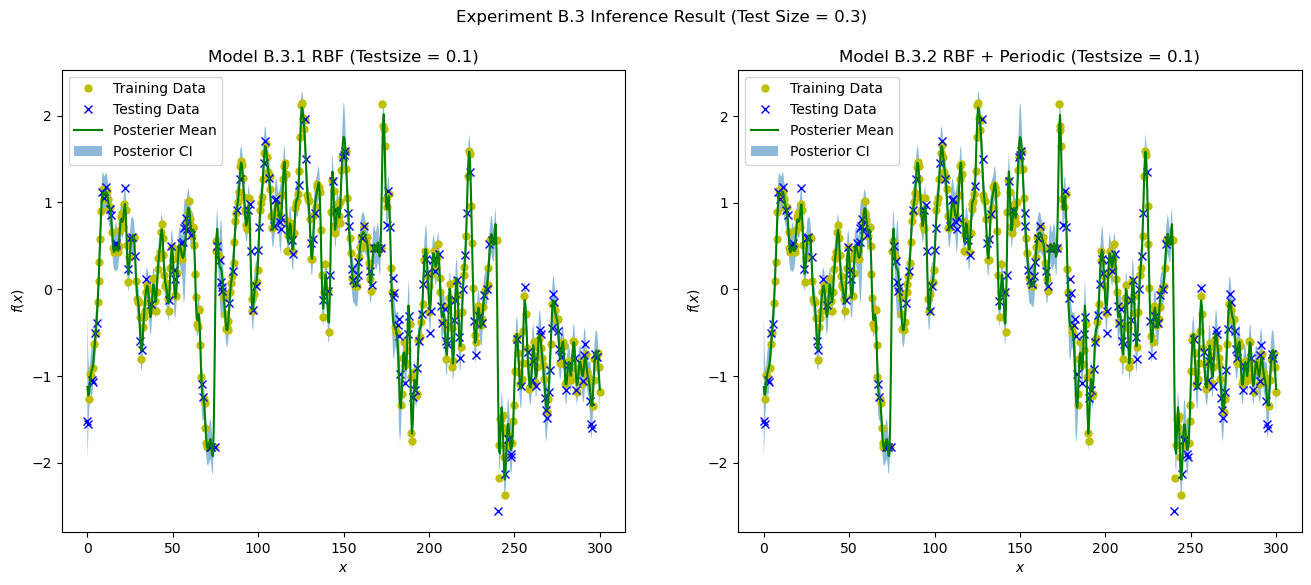

In [19]:
experiment_index1 = [2, 0]
experiment_index2 = [2, 1]

#get current training and testing set
X_train, Y_train, X_test, Y_test = get_current_training_testing_split(experiment_index1)

#get our current model and likelihood
model1, likelihood1 = GP_experiment(experiment_index1, X_train, Y_train)
time_list, train_losses_mll, test_losses_mse, test_losses_msll, training_duration =  \
    training(X_train, Y_train, X_test, Y_test, model1, likelihood1, optimizer = torch.optim.Adam(model1.parameters(), lr=0.1),\
         mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood1, model1), training_iterations = 300)
record(time_list, train_losses_mll, test_losses_mse, test_losses_msll, experiment_index1)

model2, likelihood2 = GP_experiment(experiment_index2, X_train, Y_train)
time_list, train_losses_mll, test_losses_mse, test_losses_msll, training_duration =  \
    training(X_train, Y_train, X_test, Y_test, model2, likelihood2, optimizer = torch.optim.Adam(model2.parameters(), lr=0.1),\
         mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood2, model2), training_iterations = 300)
record(time_list, train_losses_mll, test_losses_mse, test_losses_msll, experiment_index2)

plot_predicting_result(model1, likelihood1, experiment_index1, model2, likelihood2, experiment_index2, X_train, Y_train, X_test, Y_test)

### EXP B.4: Testsize = 0.4

tesing MSE after 300 epochs: 0.049788987554086256
tesing MSLL after 300 epochs: -0.2997240803940617
training duration for 300 epochs: 8.450552701950073
tesing MSE after 300 epochs: 0.049099136031180476
tesing MSLL after 300 epochs: -0.3139058140917878
training duration for 300 epochs: 14.63200569152832


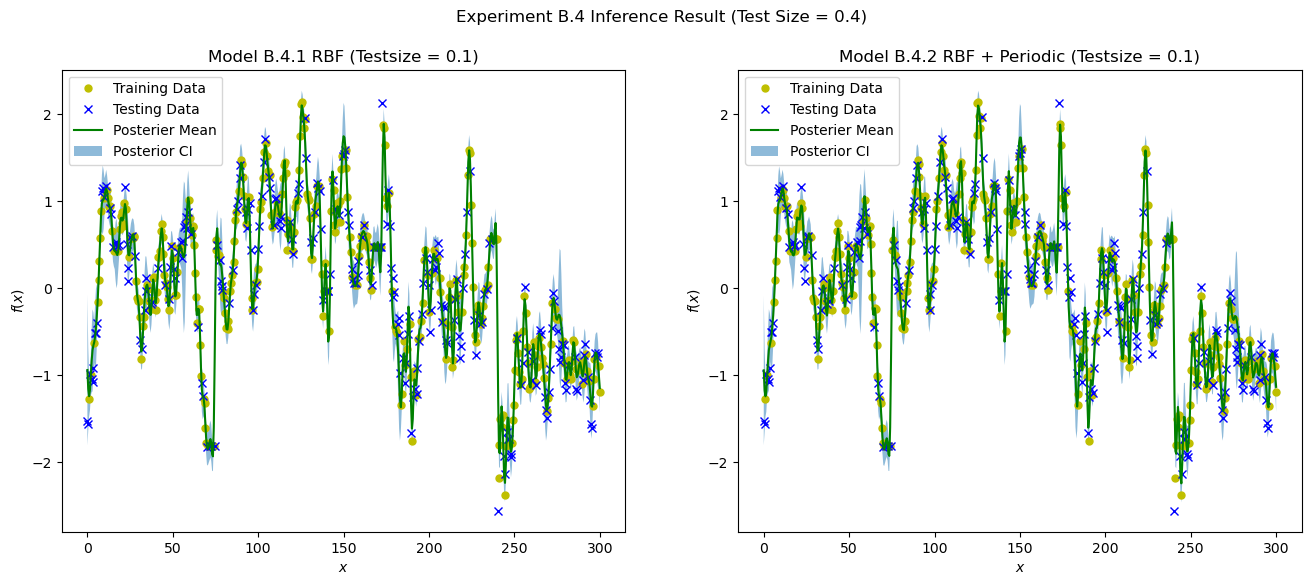

In [20]:
experiment_index1 = [3, 0]
experiment_index2 = [3, 1]

#get current training and testing set
X_train, Y_train, X_test, Y_test = get_current_training_testing_split(experiment_index1)

#get our current model and likelihood
model1, likelihood1 = GP_experiment(experiment_index1, X_train, Y_train)
time_list, train_losses_mll, test_losses_mse, test_losses_msll, training_duration =  \
    training(X_train, Y_train, X_test, Y_test, model1, likelihood1, optimizer = torch.optim.Adam(model1.parameters(), lr=0.1),\
         mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood1, model1), training_iterations = 300)
record(time_list, train_losses_mll, test_losses_mse, test_losses_msll, experiment_index1)

model2, likelihood2 = GP_experiment(experiment_index2, X_train, Y_train)
time_list, train_losses_mll, test_losses_mse, test_losses_msll, training_duration =  \
    training(X_train, Y_train, X_test, Y_test, model2, likelihood2, optimizer = torch.optim.Adam(model2.parameters(), lr=0.1),\
         mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood2, model2), training_iterations = 300)
record(time_list, train_losses_mll, test_losses_mse, test_losses_msll, experiment_index2)

plot_predicting_result(model1, likelihood1, experiment_index1, model2, likelihood2, experiment_index2, X_train, Y_train, X_test, Y_test)

### EXP B.5: Testsize = 0.5

tesing MSE after 300 epochs: 0.06581672234132177
tesing MSLL after 300 epochs: -0.36812127393849137
training duration for 300 epochs: 7.310590982437134
tesing MSE after 300 epochs: 0.06545237029925194
tesing MSLL after 300 epochs: -0.3670335941103026
training duration for 300 epochs: 12.459816932678223


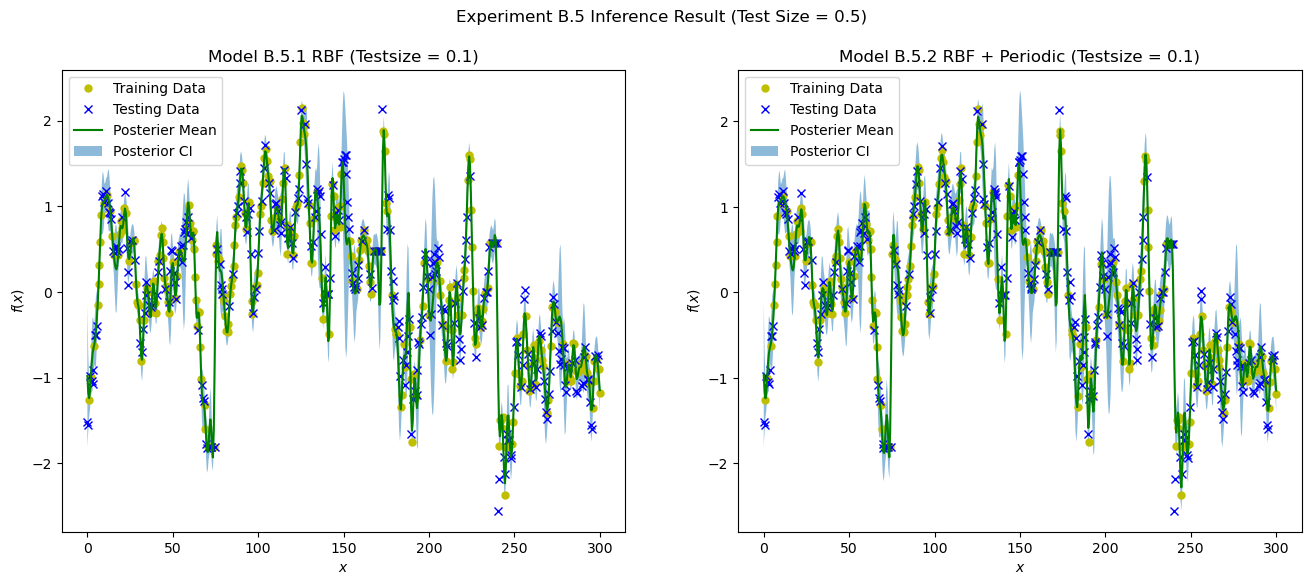

In [21]:
experiment_index1 = [4, 0]
experiment_index2 = [4, 1]

#get current training and testing set
X_train, Y_train, X_test, Y_test = get_current_training_testing_split(experiment_index1)

#get our current model and likelihood
model1, likelihood1 = GP_experiment(experiment_index1, X_train, Y_train)
time_list, train_losses_mll, test_losses_mse, test_losses_msll, training_duration =  \
    training(X_train, Y_train, X_test, Y_test, model1, likelihood1, optimizer = torch.optim.Adam(model1.parameters(), lr=0.1),\
         mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood1, model1), training_iterations = 300)
record(time_list, train_losses_mll, test_losses_mse, test_losses_msll, experiment_index1)

model2, likelihood2 = GP_experiment(experiment_index2, X_train, Y_train)
time_list, train_losses_mll, test_losses_mse, test_losses_msll, training_duration =  \
    training(X_train, Y_train, X_test, Y_test, model2, likelihood2, optimizer = torch.optim.Adam(model2.parameters(), lr=0.1),\
         mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood2, model2), training_iterations = 300)
record(time_list, train_losses_mll, test_losses_mse, test_losses_msll, experiment_index2)

plot_predicting_result(model1, likelihood1, experiment_index1, model2, likelihood2, experiment_index2, X_train, Y_train, X_test, Y_test)

### EXP B.6: Testsize = 0.6

tesing MSE after 300 epochs: 0.13154641429619954
tesing MSLL after 300 epochs: -0.04709002434863186
training duration for 300 epochs: 6.0896828174591064
tesing MSE after 300 epochs: 0.1327441117632679
tesing MSLL after 300 epochs: -0.04513471840402066
training duration for 300 epochs: 11.326663970947266


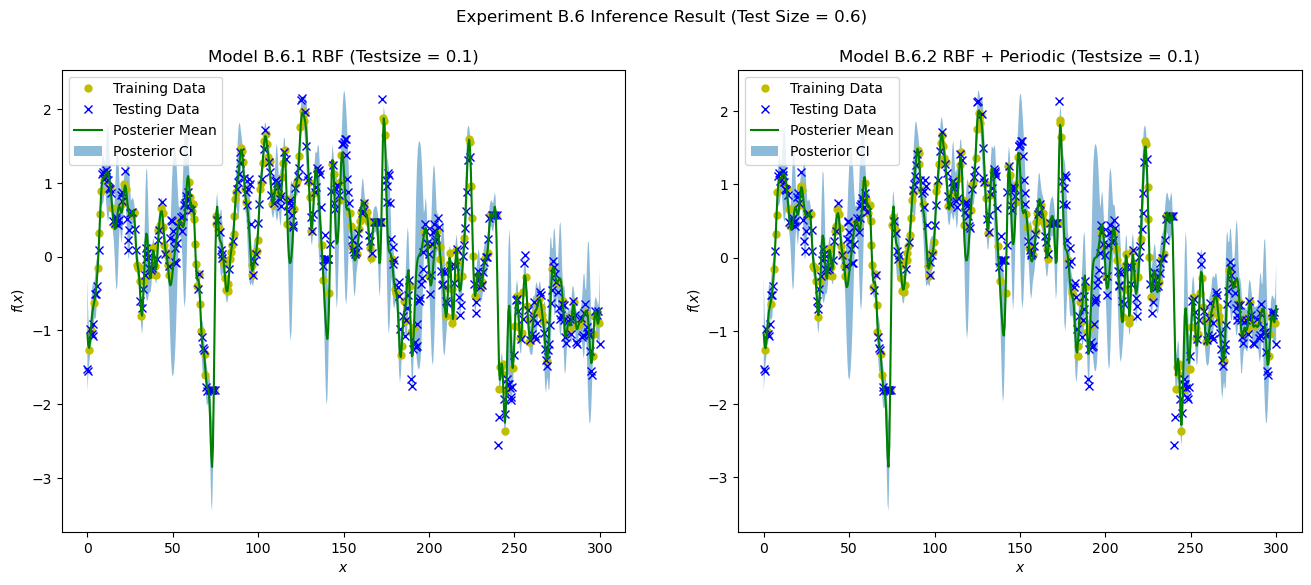

In [22]:
experiment_index1 = [5, 0]
experiment_index2 = [5, 1]

#get current training and testing set
X_train, Y_train, X_test, Y_test = get_current_training_testing_split(experiment_index1)

#get our current model and likelihood
model1, likelihood1 = GP_experiment(experiment_index1, X_train, Y_train)
time_list, train_losses_mll, test_losses_mse, test_losses_msll, training_duration =  \
    training(X_train, Y_train, X_test, Y_test, model1, likelihood1, optimizer = torch.optim.Adam(model1.parameters(), lr=0.1),\
         mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood1, model1), training_iterations = 300)
record(time_list, train_losses_mll, test_losses_mse, test_losses_msll, experiment_index1)

model2, likelihood2 = GP_experiment(experiment_index2, X_train, Y_train)
time_list, train_losses_mll, test_losses_mse, test_losses_msll, training_duration =  \
    training(X_train, Y_train, X_test, Y_test, model2, likelihood2, optimizer = torch.optim.Adam(model2.parameters(), lr=0.1),\
         mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood2, model2), training_iterations = 300)
record(time_list, train_losses_mll, test_losses_mse, test_losses_msll, experiment_index2)

plot_predicting_result(model1, likelihood1, experiment_index1, model2, likelihood2, experiment_index2, X_train, Y_train, X_test, Y_test)

### EXP B.7: Testsize = 0.7

tesing MSE after 300 epochs: 0.14972560253441225
tesing MSLL after 300 epochs: 0.026247888001305352
training duration for 300 epochs: 4.942884206771851
tesing MSE after 300 epochs: 0.14835570030638348
tesing MSLL after 300 epochs: 0.028107643102328876
training duration for 300 epochs: 8.178177118301392


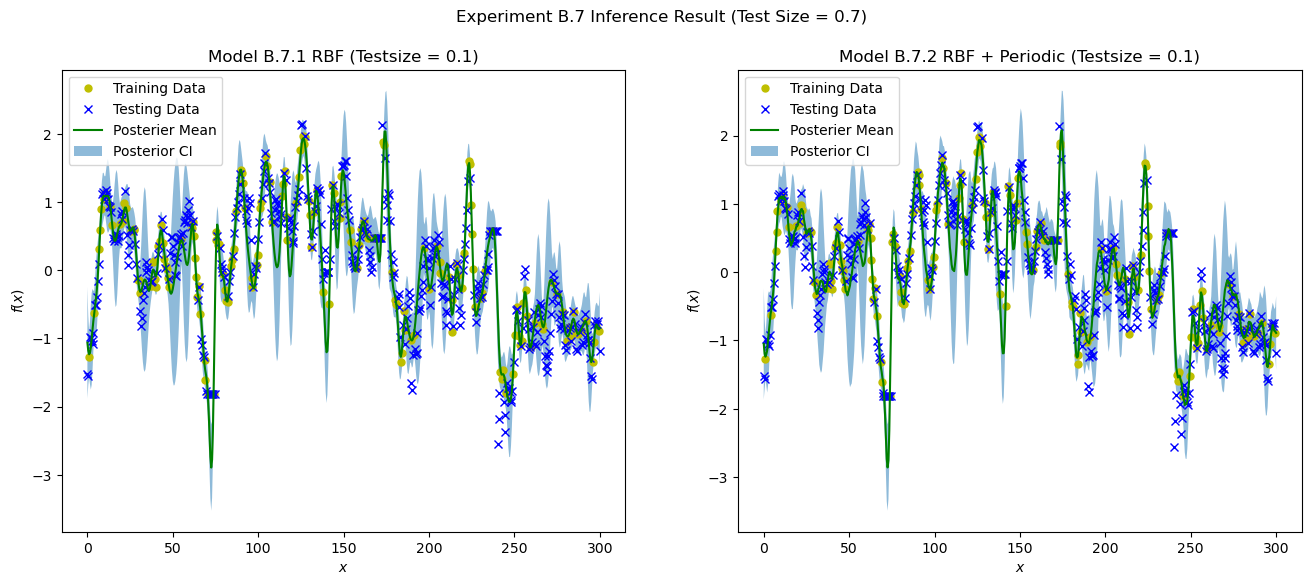

In [23]:
experiment_index1 = [6, 0]
experiment_index2 = [6, 1]

#get current training and testing set
X_train, Y_train, X_test, Y_test = get_current_training_testing_split(experiment_index1)

#get our current model and likelihood
model1, likelihood1 = GP_experiment(experiment_index1, X_train, Y_train)
time_list, train_losses_mll, test_losses_mse, test_losses_msll, training_duration =  \
    training(X_train, Y_train, X_test, Y_test, model1, likelihood1, optimizer = torch.optim.Adam(model1.parameters(), lr=0.1),\
         mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood1, model1), training_iterations = 300)
record(time_list, train_losses_mll, test_losses_mse, test_losses_msll, experiment_index1)

model2, likelihood2 = GP_experiment(experiment_index2, X_train, Y_train)
time_list, train_losses_mll, test_losses_mse, test_losses_msll, training_duration =  \
    training(X_train, Y_train, X_test, Y_test, model2, likelihood2, optimizer = torch.optim.Adam(model2.parameters(), lr=0.1),\
         mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood2, model2), training_iterations = 300)
record(time_list, train_losses_mll, test_losses_mse, test_losses_msll, experiment_index2)

plot_predicting_result(model1, likelihood1, experiment_index1, model2, likelihood2, experiment_index2, X_train, Y_train, X_test, Y_test)

### EXP B.8: Testsize = 0.8

tesing MSE after 300 epochs: 0.16195758803167623
tesing MSLL after 300 epochs: 0.1415665742305862
training duration for 300 epochs: 3.782874822616577
tesing MSE after 300 epochs: 0.1712319332491461
tesing MSLL after 300 epochs: 0.17045331007221734
training duration for 300 epochs: 6.614591836929321


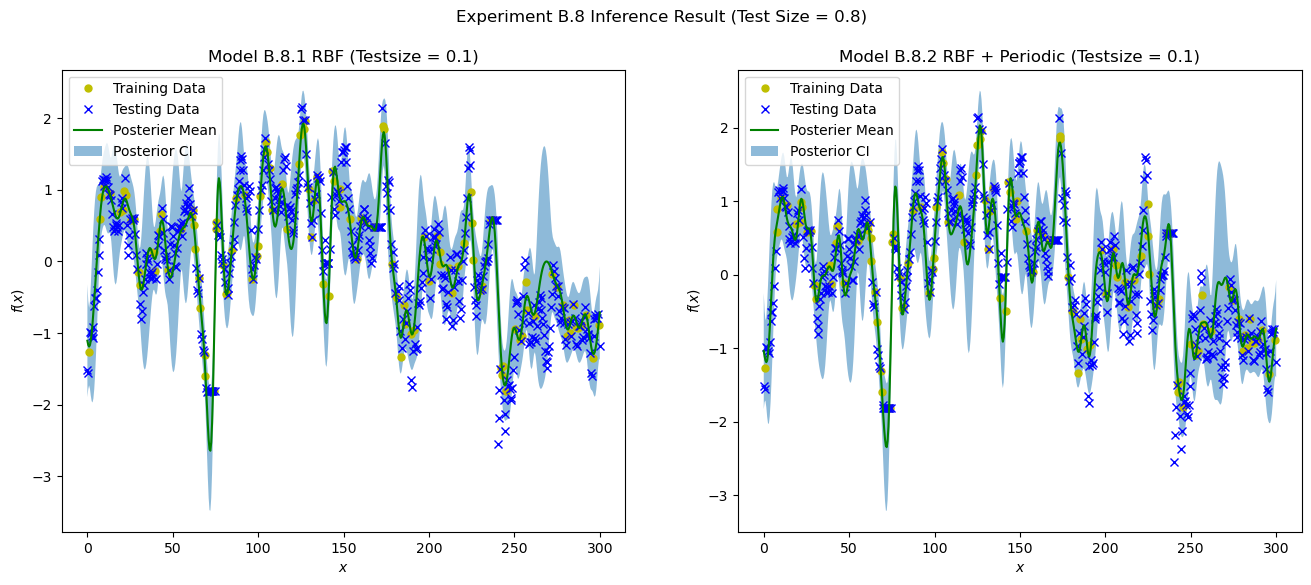

In [24]:
experiment_index1 = [7, 0]
experiment_index2 = [7, 1]

#get current training and testing set
X_train, Y_train, X_test, Y_test = get_current_training_testing_split(experiment_index1)

#get our current model and likelihood
model1, likelihood1 = GP_experiment(experiment_index1, X_train, Y_train)
time_list, train_losses_mll, test_losses_mse, test_losses_msll, training_duration =  \
    training(X_train, Y_train, X_test, Y_test, model1, likelihood1, optimizer = torch.optim.Adam(model1.parameters(), lr=0.1),\
         mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood1, model1), training_iterations = 300)
record(time_list, train_losses_mll, test_losses_mse, test_losses_msll, experiment_index1)

model2, likelihood2 = GP_experiment(experiment_index2, X_train, Y_train)
time_list, train_losses_mll, test_losses_mse, test_losses_msll, training_duration =  \
    training(X_train, Y_train, X_test, Y_test, model2, likelihood2, optimizer = torch.optim.Adam(model2.parameters(), lr=0.1),\
         mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood2, model2), training_iterations = 300)
record(time_list, train_losses_mll, test_losses_mse, test_losses_msll, experiment_index2)

plot_predicting_result(model1, likelihood1, experiment_index1, model2, likelihood2, experiment_index2, X_train, Y_train, X_test, Y_test)

### EXP B.9: Testsize = 0.9

tesing MSE after 300 epochs: 0.3944638528056975
tesing MSLL after 300 epochs: 0.4421851364721118
training duration for 300 epochs: 2.482573986053467
tesing MSE after 300 epochs: 0.3996082755927912
tesing MSLL after 300 epochs: 0.45845651419210215
training duration for 300 epochs: 3.923832654953003


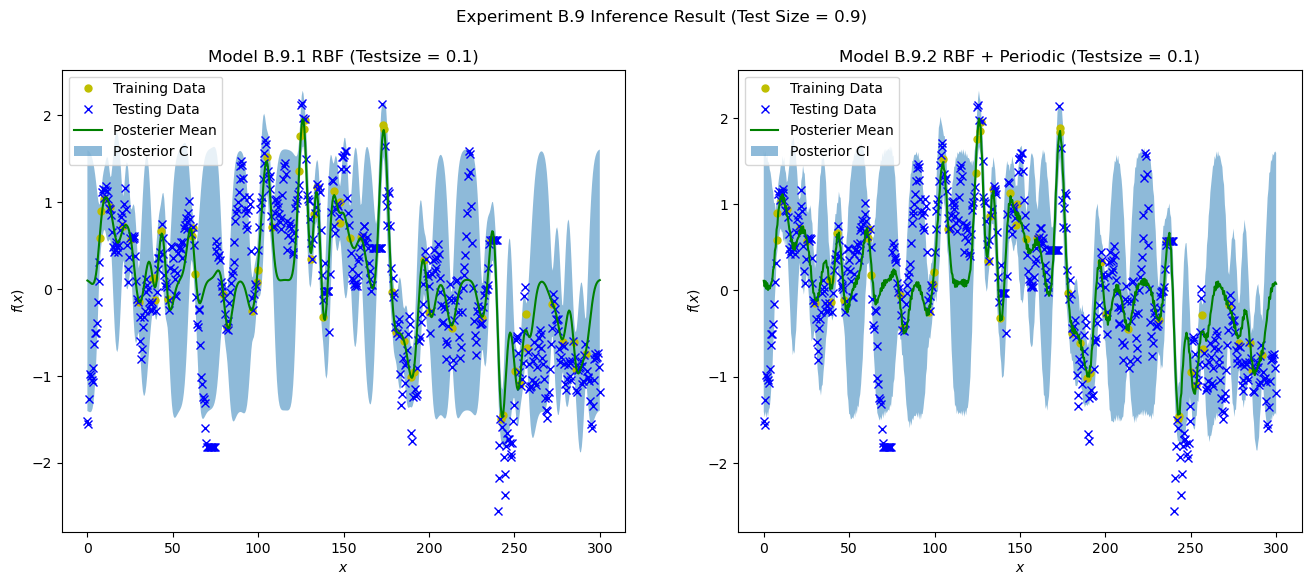

In [25]:
experiment_index1 = [8, 0]
experiment_index2 = [8, 1]

#get current training and testing set
X_train, Y_train, X_test, Y_test = get_current_training_testing_split(experiment_index1)

#get our current model and likelihood
model1, likelihood1 = GP_experiment(experiment_index1, X_train, Y_train)
time_list, train_losses_mll, test_losses_mse, test_losses_msll, training_duration =  \
    training(X_train, Y_train, X_test, Y_test, model1, likelihood1, optimizer = torch.optim.Adam(model1.parameters(), lr=0.1),\
         mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood1, model1), training_iterations = 300)
record(time_list, train_losses_mll, test_losses_mse, test_losses_msll, experiment_index1)

model2, likelihood2 = GP_experiment(experiment_index2, X_train, Y_train)
time_list, train_losses_mll, test_losses_mse, test_losses_msll, training_duration =  \
    training(X_train, Y_train, X_test, Y_test, model2, likelihood2, optimizer = torch.optim.Adam(model2.parameters(), lr=0.1),\
         mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood2, model2), training_iterations = 300)
record(time_list, train_losses_mll, test_losses_mse, test_losses_msll, experiment_index2)

plot_predicting_result(model1, likelihood1, experiment_index1, model2, likelihood2, experiment_index2, X_train, Y_train, X_test, Y_test)

# Speed and Error Log Analysis

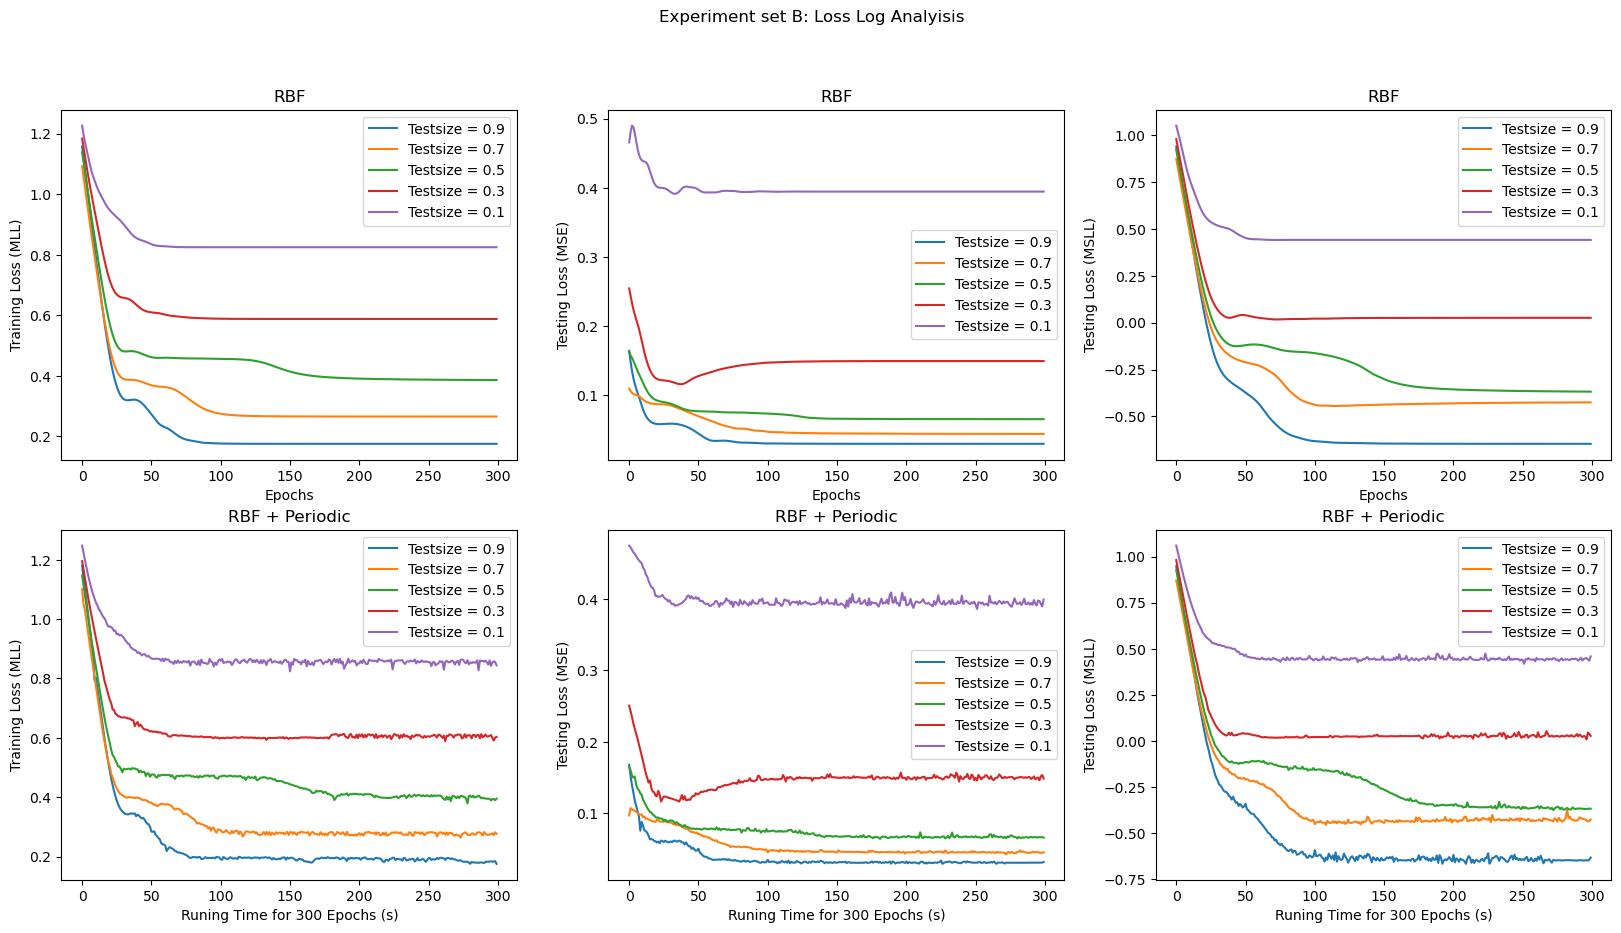

In [40]:
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
fig.suptitle('Experiment set B: Loss Log Analyisis')

axs[0, 0].plot(train_losses_mll_list[0][0], label = 'Testsize = 0.9')
axs[0, 0].plot(train_losses_mll_list[2][0], label = 'Testsize = 0.7')
axs[0, 0].plot(train_losses_mll_list[4][0], label = 'Testsize = 0.5')
axs[0, 0].plot(train_losses_mll_list[6][0], label = 'Testsize = 0.3')
axs[0, 0].plot(train_losses_mll_list[8][0], label = 'Testsize = 0.1')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Training Loss (MLL)')
axs[0, 0].set_title('RBF')
axs[0, 0].legend()

axs[1, 0].plot(train_losses_mll_list[0][1], label = 'Testsize = 0.9')
axs[1, 0].plot(train_losses_mll_list[2][1], label = 'Testsize = 0.7')
axs[1, 0].plot(train_losses_mll_list[4][1], label = 'Testsize = 0.5')
axs[1, 0].plot(train_losses_mll_list[6][1], label = 'Testsize = 0.3')
axs[1, 0].plot(train_losses_mll_list[8][1], label = 'Testsize = 0.1')
axs[1, 0].set_xlabel('Runing Time for 300 Epochs (s)')
axs[1, 0].set_ylabel('Training Loss (MLL)')
axs[1, 0].set_title('RBF + Periodic')
axs[1, 0].legend()

axs[0, 1].plot(test_losses_mse_list[0][0], label = 'Testsize = 0.9')
axs[0, 1].plot(test_losses_mse_list[2][0], label = 'Testsize = 0.7')
axs[0, 1].plot(test_losses_mse_list[4][0], label = 'Testsize = 0.5')
axs[0, 1].plot(test_losses_mse_list[6][0], label = 'Testsize = 0.3')
axs[0, 1].plot(test_losses_mse_list[8][0], label = 'Testsize = 0.1')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('Testing Loss (MSE)')
axs[0, 1].set_title('RBF')
axs[0, 1].legend()

axs[1, 1].plot(test_losses_mse_list[0][1], label = 'Testsize = 0.9')
axs[1, 1].plot(test_losses_mse_list[2][1], label = 'Testsize = 0.7')
axs[1, 1].plot(test_losses_mse_list[4][1], label = 'Testsize = 0.5')
axs[1, 1].plot(test_losses_mse_list[6][1], label = 'Testsize = 0.3')
axs[1, 1].plot(test_losses_mse_list[8][1], label = 'Testsize = 0.1')
axs[1, 1].set_xlabel('Runing Time for 300 Epochs (s)')
axs[1, 1].set_ylabel('Testing Loss (MSE)')
axs[1, 1].set_title('RBF + Periodic')
axs[1, 1].legend()


axs[0, 2].plot(test_losses_msll_list[0][0], label = 'Testsize = 0.9')
axs[0, 2].plot(test_losses_msll_list[2][0], label = 'Testsize = 0.7')
axs[0, 2].plot(test_losses_msll_list[4][0], label = 'Testsize = 0.5')
axs[0, 2].plot(test_losses_msll_list[6][0], label = 'Testsize = 0.3')
axs[0, 2].plot(test_losses_msll_list[8][0], label = 'Testsize = 0.1')
axs[0, 2].set_xlabel('Epochs')
axs[0, 2].set_ylabel('Testing Loss (MSLL)')
axs[0, 2].set_title('RBF')
axs[0, 2].legend()

axs[1, 2].plot(test_losses_msll_list[0][1], label = 'Testsize = 0.9')
axs[1, 2].plot(test_losses_msll_list[2][1], label = 'Testsize = 0.7')
axs[1, 2].plot(test_losses_msll_list[4][1], label = 'Testsize = 0.5')
axs[1, 2].plot(test_losses_msll_list[6][1], label = 'Testsize = 0.3')
axs[1, 2].plot(test_losses_msll_list[8][1], label = 'Testsize = 0.1')
axs[1, 2].set_xlabel('Runing Time for 300 Epochs (s)')
axs[1, 2].set_ylabel('Testing Loss (MSLL)')
axs[1, 2].set_title('RBF + Periodic')
axs[1, 2].legend()



# save_to = 'Experiment_B_Figure/Training Speed Analysis.png'
# plt.savefig(save_to)